In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'vg16_trf_learning.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip
! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Brain_MRI/Training/glioma/Tr-gl_0726.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0727.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0728.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0729.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0730.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0731.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0732.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0733.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0734.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0735.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0736.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0737.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0738.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0739.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0740.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0741.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0742.jpg

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Brain_MRI/Testing/"

## Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
glioma        120
pituitary     120
notumor       120
dtype: int64

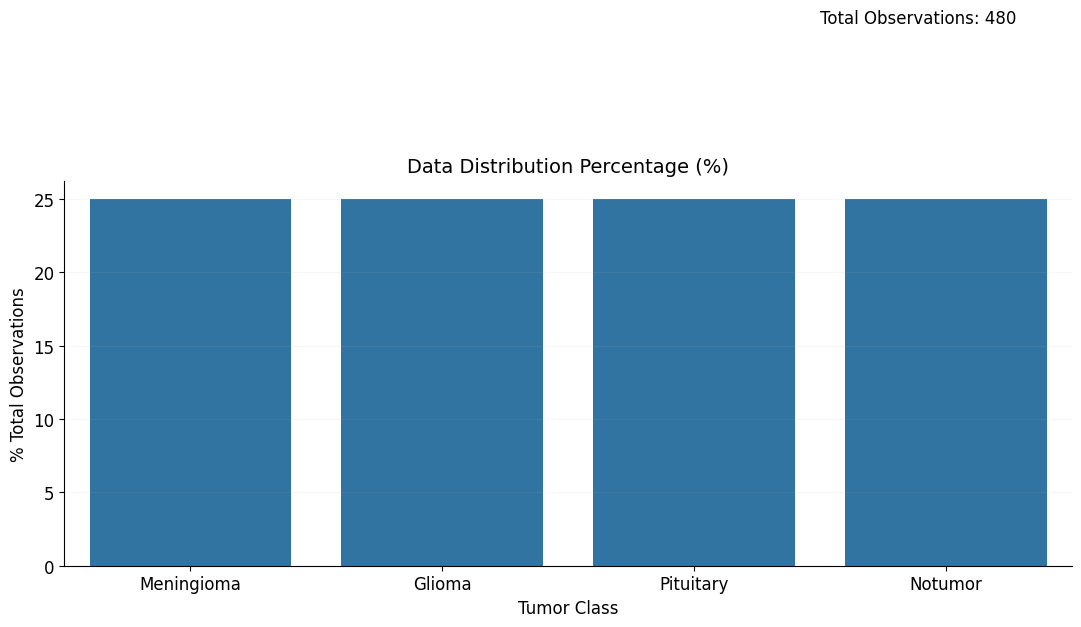

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data


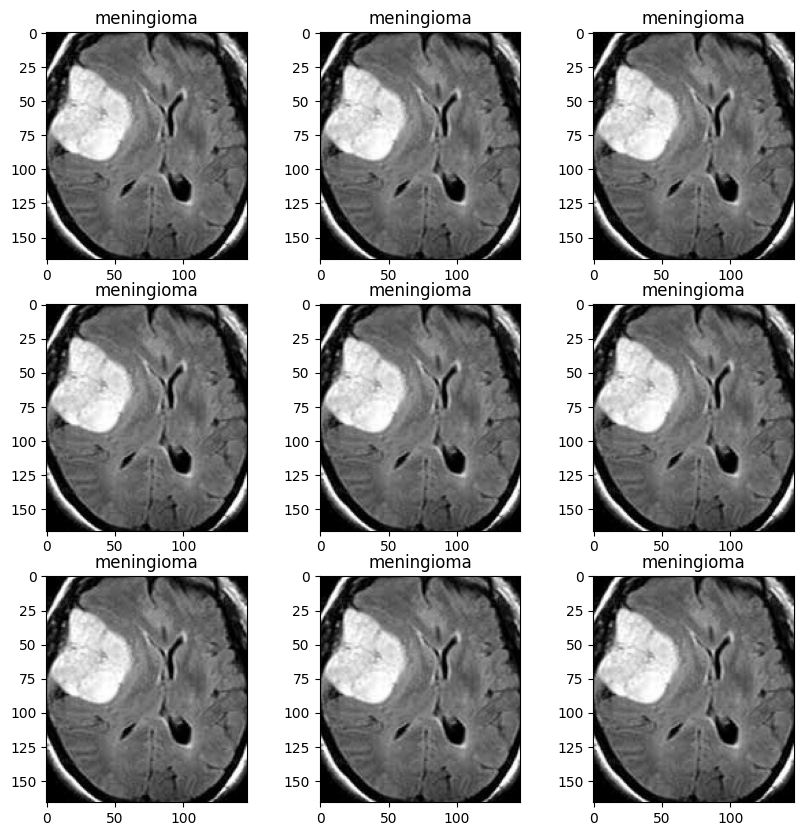

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)
preprocess_images(validation_dir)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            plt.title(curr_index)
            plt.imshow(image)
            break
        break

## Splitting the data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


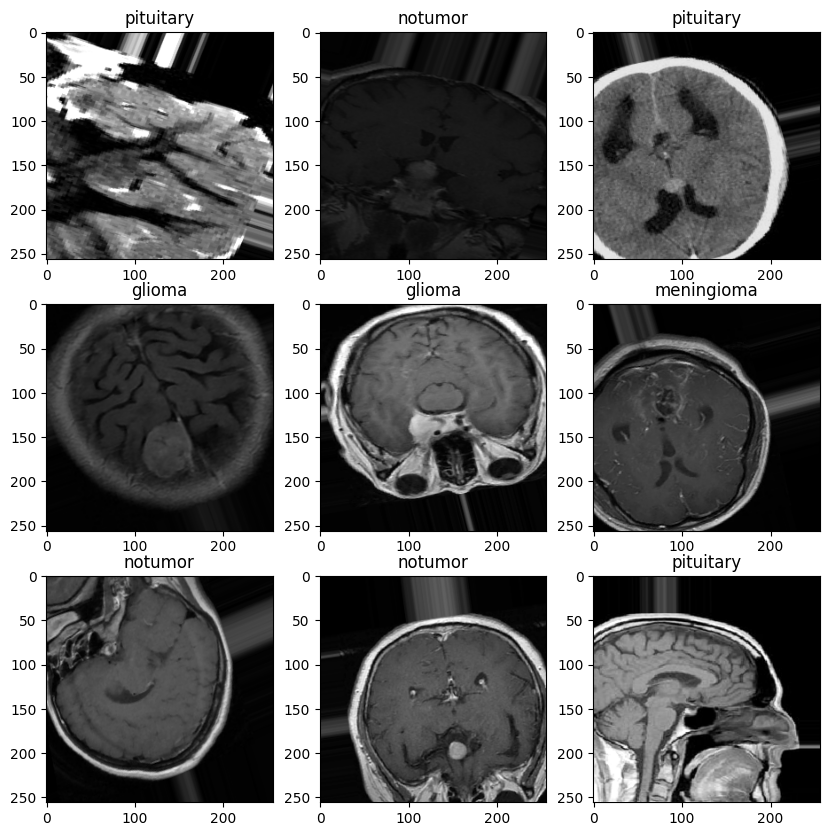

In [8]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = [0.3, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=32,
    seed=42,
    subset='validation')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    seed=42,
    batch_size=32
)

print(test_generator.class_indices)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        # Print Class
        plt.title(classes[np.argmax(Y_batch[0])])

        plt.imshow(image)
        break



# Training a VGG16 model

In [9]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten
from keras.utils import plot_model
from tensorflow.keras.applications import VGG16

def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Check if the model exists
if os.path.exists(model_file):
    # Load the model from the file
    model = load_model(model_file)
else:
    # Create a new model
    model = VGG16_trf_learning((256, 256, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

# Train the model

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.7102 - accuracy: 0.3125
Epoch 1: val_loss improved from inf to 1.39749, saving model to ./models/vg16_trf_learning.keras
12/12 [==============================] - 25s 1s/step - loss: 1.7102 - accuracy: 0.3125 - val_loss: 1.3975 - val_accuracy: 0.4375
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.3380 - accuracy: 0.3880
Epoch 2: val_loss improved from 1.39749 to 1.16285, saving model to ./models/vg16_trf_learning.keras
12/12 [==============================] - 13s 1s/step - loss: 1.3380 - accuracy: 0.3880 - val_loss: 1.1629 - val_accuracy: 0.4688
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2225 - accuracy: 0.4505
Epoch 3: val_loss improved from 1.16285 to 1.08856, saving model to ./models/vg16_trf_learning.keras
12/12 [==============================] - 15s 1s/step - loss: 1.2225 - accuracy: 0.4505 - val_loss: 1.0886 - val_accuracy: 0.4792
Epoch 4/50
12/12 [==============

# Testing the Model

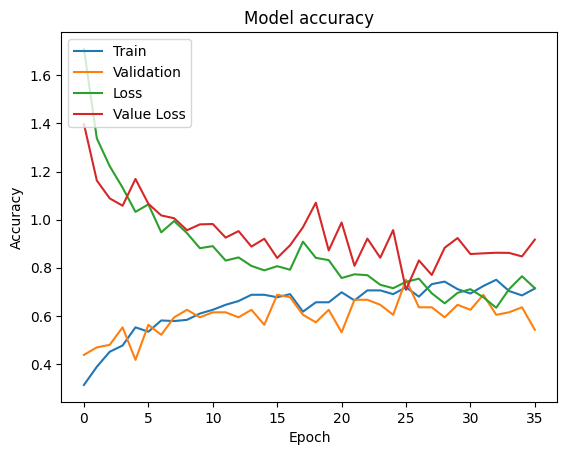

In [11]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

41/41 [==============================] - 7s 165ms/step


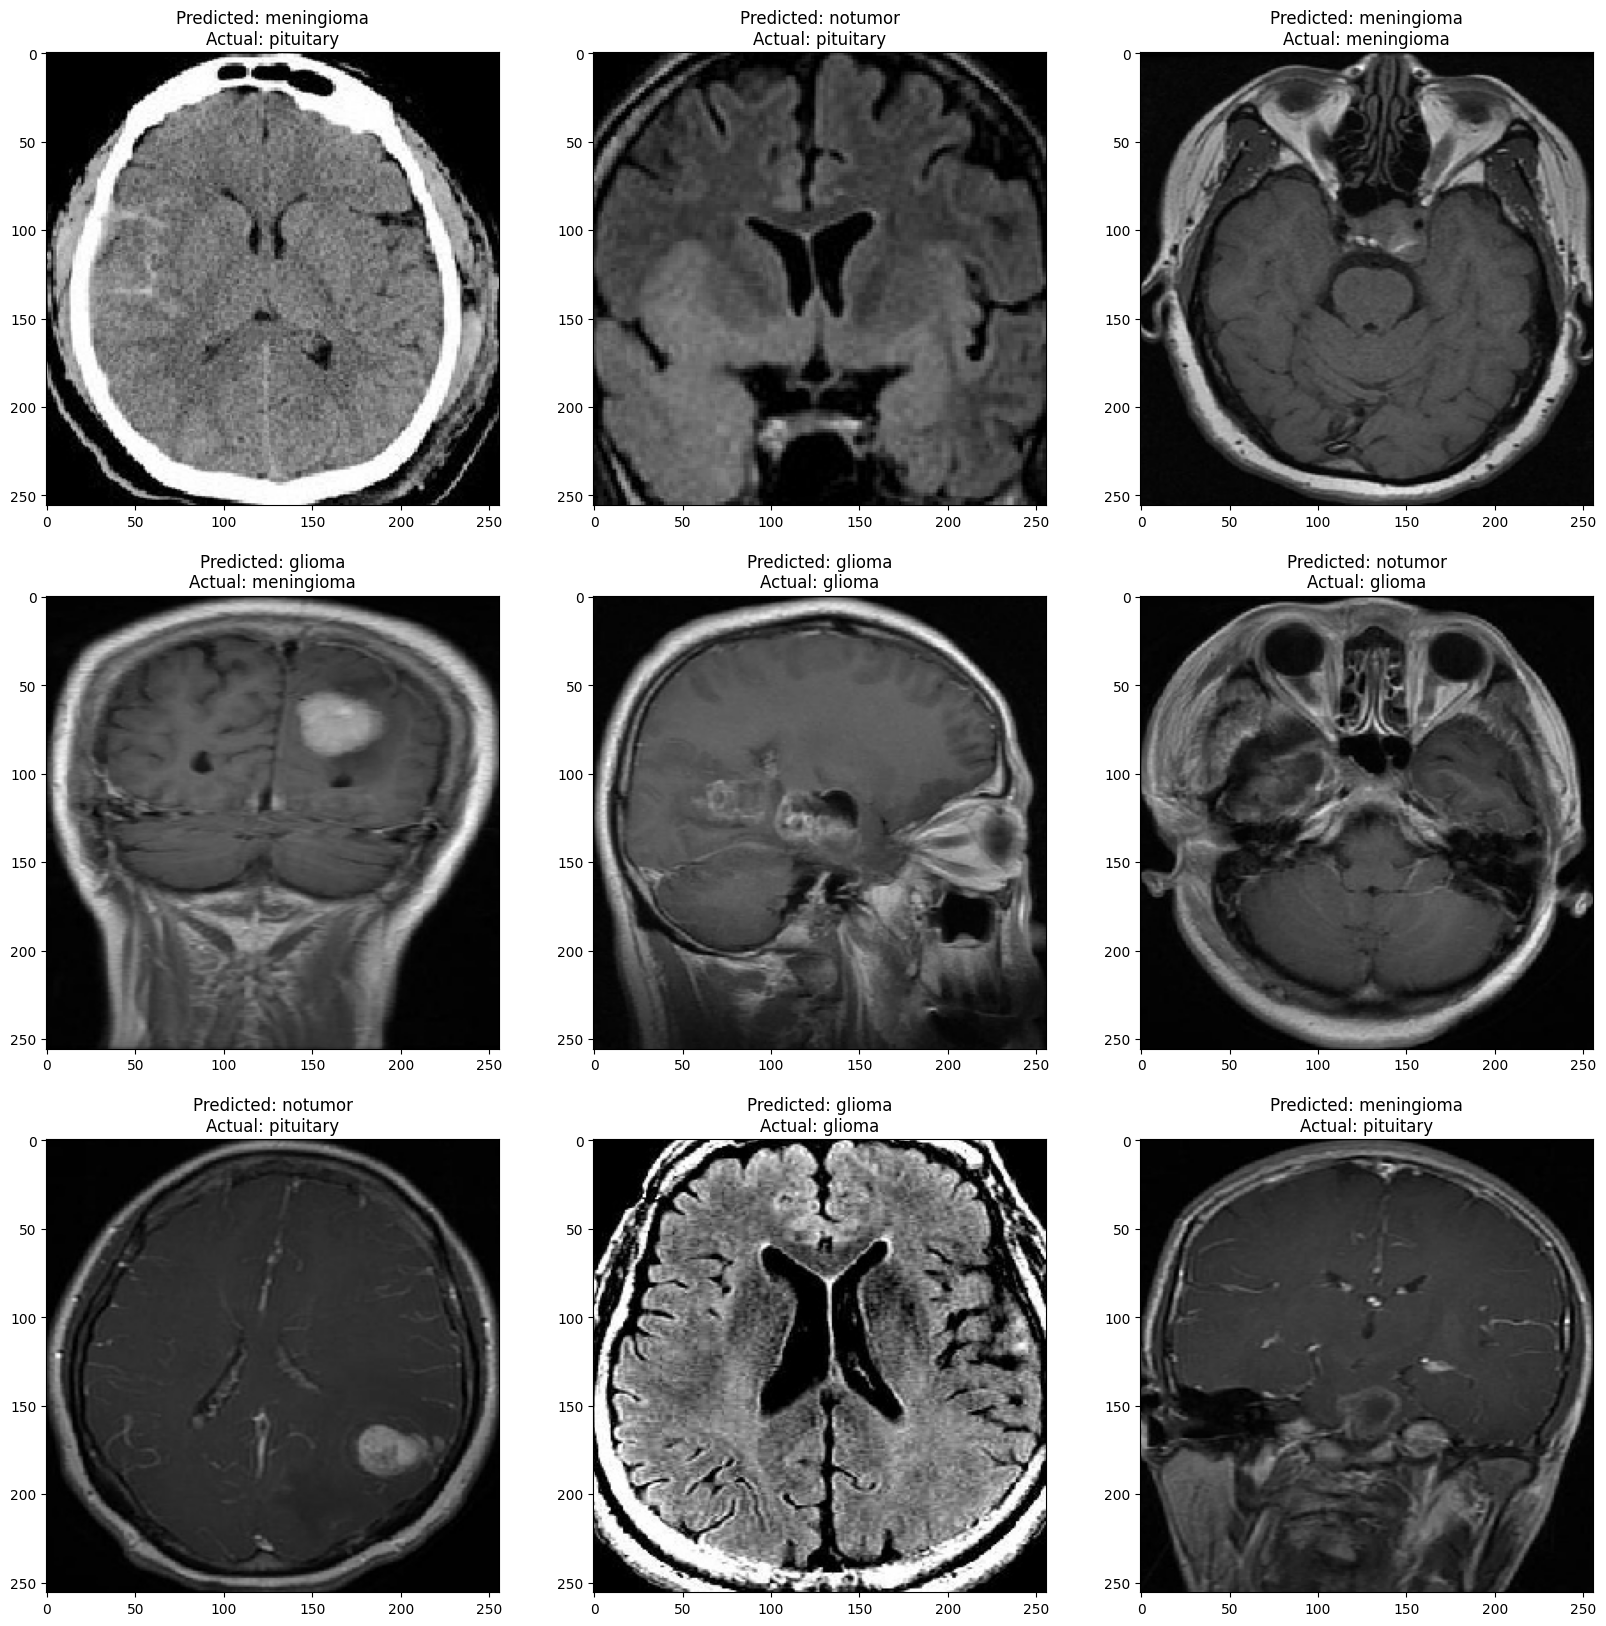

In [12]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(validation_generator)

# Predict the output
predictions = model.predict(validation_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


# Model Visualisation (Evaluation)

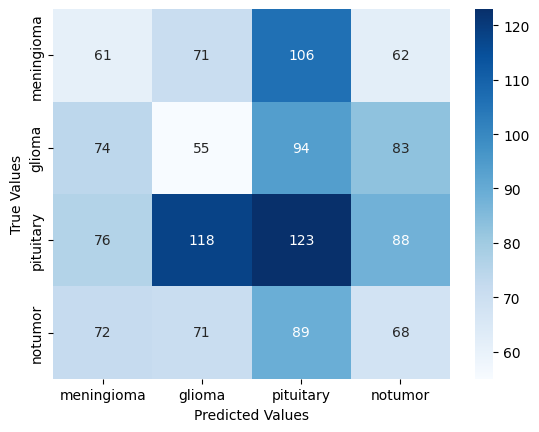

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
